In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pickle
import pygenstability as pgs

from matplotlib.pyplot import figure
from pygenstability import plotting
from scipy.linalg import block_diag

from msfiltration import MCF

In [2]:
root_fig = '/home/tc/OneDrive/Software/MSFiltration/paper/figures/'
plt.rcParams.update({'font.size': 20})

# Construct multiscale stochastic block model (mSBM)

In [3]:
def block(n, th, rng):
    A = rng.uniform(0, 1, (n, n))
    A[A < th] = 0.0
    A[A > th] = 1.0
    A = (A + A.T) / 2
    return A


# define size and strength of multiscale structure
n0 = 270
th0 = 0.995

n1 = 3
th1 = 0.95

n2 = 9
th2 = 0.8

n3 = 27
th3 = 0.2

# construct adjacency matrix
rng = np.random.RandomState(1)
A = block(n0, th0, rng)
A += block_diag(*[block(int(n0 / n1), th1, rng) for i in range(n1)])
A += block_diag(*[block(int(n0 / n2), th2, rng) for i in range(n2)])
A += block_diag(*[block(int(n0 / n3), th3, rng) for i in range(n3)])

# binarized
A[A > 0] = 1

# remove self-loops
A -= np.diag(np.diag(A))

Graph with 270 nodes and 3428 edges


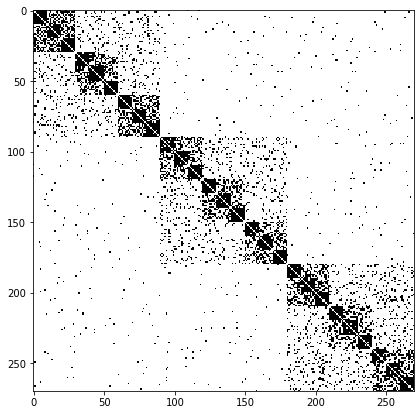

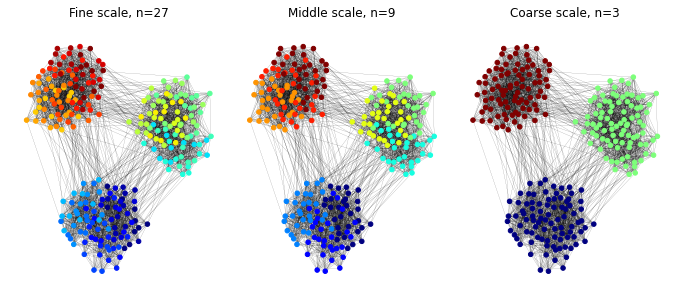

In [4]:
# plot matrix
plt.figure(figsize=(8, 7))
plt.imshow(A, interpolation="nearest",cmap='binary')
# plt.savefig(root_fig +'SBM_adjacency_matrix.pdf', bbox_inches='tight')

# Multiscale structure
coarse_scale_id = np.zeros(n0)
middle_scale_id = np.zeros(n0)
fine_scale_id = np.zeros(n0)

for i in range(n1):
    coarse_scale_id[(i * n0 // n1) : ((i + 1) * n0 // n1)] = i

for i in range(n2):
    middle_scale_id[(i * n0 // n2) : ((i + 1) * n0 // n2)] = i

for i in range(n3):
    fine_scale_id[(i * n0 // n3) : ((i + 1) * n0 // n3)] = i

# Create nx graph
G = nx.from_numpy_array(A)

# Compute spring layout
pos = nx.layout.spring_layout(G, seed=2)

# Plot multiscale graph structure
fig, axes = plt.subplots(1, 3, figsize=(12, 5))
fig.subplots_adjust(hspace=0.4, wspace=0)


nx.draw(
    G,
    ax=axes[0],
    pos=pos,
    node_size=20,
    arrows=False,
    width=0.1,
    node_color=fine_scale_id,
    cmap="jet",
)
axes[0].set(title=r"Fine scale, n=27")

nx.draw(
    G,
    ax=axes[1],
    pos=pos,
    node_size=20,
    arrows=False,
    width=0.1,
    node_color=middle_scale_id,
    cmap="jet",
)
axes[1].set(title=r"Middle scale, n=9")

nx.draw(
    G,
    ax=axes[2],
    pos=pos,
    node_size=20,
    arrows=False,
    width=0.1,
    node_color=coarse_scale_id,
    cmap="jet",
)
axes[2].set(title=r"Coarse scale, n=3")

print(G)

In [5]:
root_fig = '/home/tc/OneDrive/Software/MSFiltration/paper/figures/'
plt.rcParams.update({'font.size': 20})

# Apply MS analysis


In [6]:
# Set MS parameters
n_scale = 200
min_scale = -1.5
max_scale = 0.5

In [7]:
# # Run MS analysis
MS_results = pgs.run(A,min_scale= min_scale,max_scale= max_scale,n_scale= n_scale,n_workers=4, constructor="continuous_normalized")

100%|██████████| 200/200 [00:30<00:00,  6.62it/s]


In [8]:
# # Load data (deserialize)
# with open("mSBM_MS_results.pkl", 'rb') as handle:
#     MS_results = pickle.load(handle)

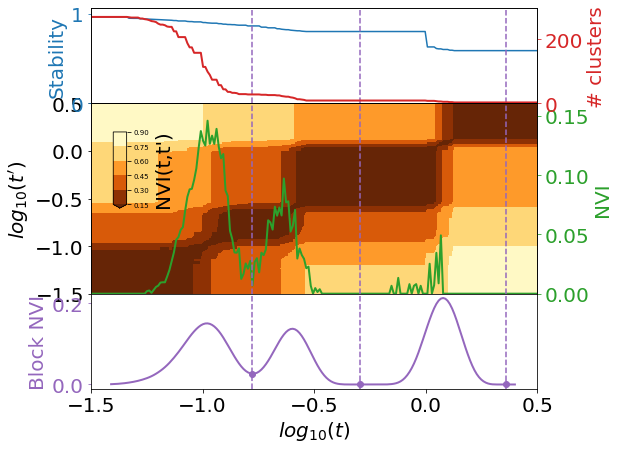

In [9]:
figure(figsize=(8, 7))
plotting.plot_scan(MS_results)
plt.show()

# Apply MCF

In [10]:
partitions = MS_results["community_id"]
log_scales = np.log10(MS_results['scales'])

In [11]:
# n_partitions = len(partitions)
# n_nodes = len(partitions[0])
# partitions_matrix = np.zeros((n_nodes,n_partitions))

# for i in range(0,n_partitions):
#     partitions_matrix[:,i] = partitions[i]

# partitions_matrix = np.asarray(partitions_matrix, dtype="int")

# np.savetxt("mSBM_Partitions.csv", partitions_matrix.astype(int), fmt='%i', delimiter=',')

In [12]:
# initialise MCF object
mcf = MCF()
mcf.load_data(partitions,log_scales)

# build filtration and compute PH
mcf.build_filtration()
mcf.compute_persistence()

Constructing filtration with GUDHI ...


100%|██████████| 200/200 [00:07<00:00, 27.17it/s]


Computing persistence with GUDHI ... 


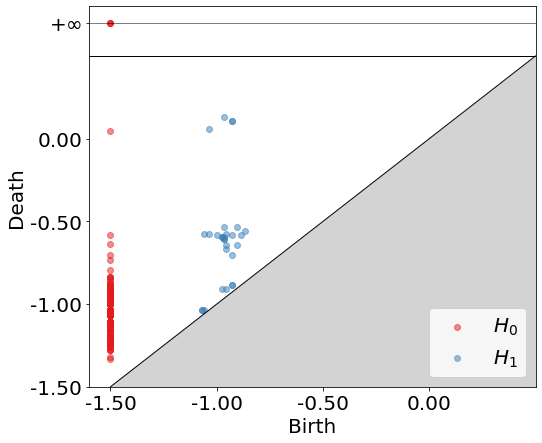

In [13]:
# Plot persistence diagram
ax = mcf.plot_persistence_diagram()

In [14]:
from msfiltration.measures import compute_persistent_hierarchy, compute_persistent_conflict, compute_beta_0, compute_partition_size, compute_birth_count, compute_death_count

In [15]:
betti_numbers = np.zeros((n_partitions,3))
for m in range((n_partitions)):
    betti_numbers[m] = mcf.filtration_gudhi.persistent_betti_numbers(log_scales[m],log_scales[m])


betti_0 = betti_numbers[:,0]
betti_1 = betti_numbers[:,1]
betti_2 = betti_numbers[:,2]

s_partitions = compute_partition_size(mcf)

h = betti_0/s_partitions

h_bar = np.mean(h)
print("Average persistent hierarchy:", np.around(h_bar,3))

total_1 = np.cumsum(compute_birth_count(mcf, 1))
resolved_1 = np.cumsum(compute_death_count(mcf, 1)[:-1])

b_1 = compute_birth_count(mcf, 1)
d_1 = compute_death_count(mcf, 1)[:-1]

total_2 = np.cumsum(compute_birth_count(mcf, 2))
resolved_2 = np.cumsum(compute_death_count(mcf, 2)[:-1])

b_2 = compute_birth_count(mcf, 2)
d_2 = compute_death_count(mcf, 2)[:-1]

c_1 = b_1 - d_1
c_2 = b_2 - d_2

# c_1 = np.nan_to_num(resolved_1/total_1,nan=1)
# c_1_bar = np.mean(c_1)
# print("Average 1-dim persistent conflict:", np.around(c_1_bar,3))


# c_2 = np.nan_to_num(resolved_2/total_2,nan=1)
# c_2_bar = np.mean(c_2)
# print("Average 2-dim persistent conflict:", np.around(c_2_bar,3))

# c = np.nan_to_num((resolved_1+resolved_2)/(total_1+total_2),nan=1)
# c_bar = np.mean(c)
# print("Average 1&2-dim persistent conflict:", np.around(c_bar,3))

NameError: name 'n_partitions' is not defined

[Text(0.5, 0, '$\\log(t)$')]

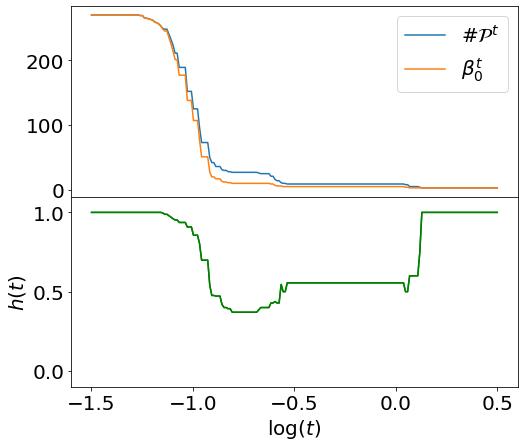

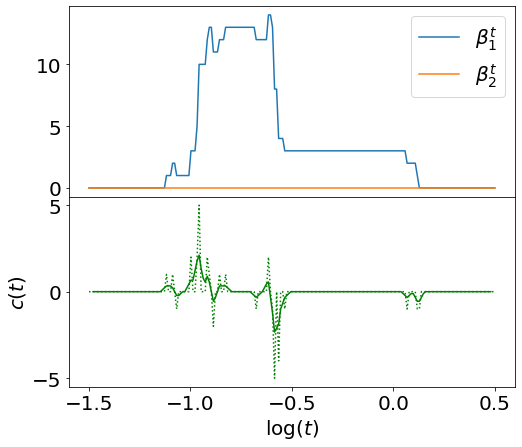

In [ ]:
fig, axs = plt.subplots(2, figsize=(8, 7))
fig.subplots_adjust(hspace=0.0, wspace=0.3)
ax1 = axs[0]
ax2 = axs[1]
ax1.plot(log_scales,s_partitions, label = r'$\#\mathcal{P}^t$')
ax1.plot(log_scales,betti_numbers[:,0], label = r'$\beta_0^t$')
ax1.set(xticks=[])

ax1.legend()

ax2.plot(log_scales,compute_persistent_hierarchy(mcf), label = r'$h(t)$',c='green')
ax2.plot(log_scales,h, label = r'$h(t)$',c='green')
ax2.set_ylabel(r'$h(t)$')
ax2.set(xlabel=r'$\log(t)$',ylim=(-0.1,1.1))
#ax2.legend()
#plt.savefig(root_fig +'SBM_persistence_hierarchy.pdf', dpi=fig.dpi,bbox_inches='tight')

import pandas as pd

def moving_average(x, w):
    return np.roll(
        np.asarray(pd.Series(x).rolling(window=w, win_type="triang").mean()),
        -int(w / 2),
    )

fig, axs = plt.subplots(2, figsize=(8, 7))
fig.subplots_adjust(hspace=0.0, wspace=0.3)
ax1 = axs[0]
ax2 = axs[1]

ax1.plot(log_scales,betti_1, label = r'$\beta_1^t$')
ax1.plot(log_scales,betti_2, label = r'$\beta_2^t$')

ax1.set(xticks=[])

ax1.legend()
ax2.plot(log_scales,c_1,c='green',ls=":")
ax2.plot(log_scales,moving_average(c_1,5),c='green')
ax2.set_ylabel(r'$c(t)$')#, color="green")
ax2.set(xlabel=r'$\log(t)$')#,ylim=(-0.1,1.1))
#ax2.legend()
#plt.savefig(root_fig +'SBM_persistence_hierarchy.pdf', dpi=fig.dpi,bbox_inches='tight')

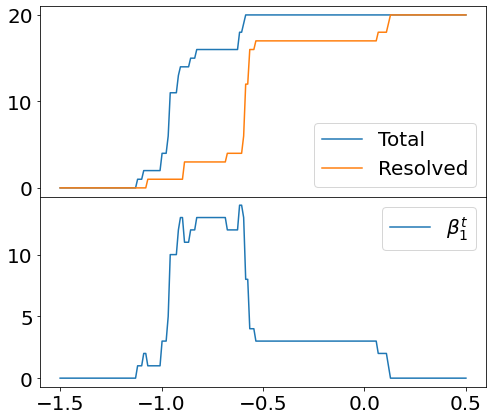

In [ ]:
fig, axs = plt.subplots(2, figsize=(8, 7))
fig.subplots_adjust(hspace=0.0, wspace=0.3)
ax1 = axs[0]
ax2 = axs[1]

ax1.plot(log_scales,total_1,label="Total")
ax1.plot(log_scales,resolved_1,label="Resolved")
ax1.set(xticks=[])

ax1.legend()
ax2.plot(log_scales,betti_1, label = r'$\beta_1^t$')
#ax2.set_ylabel(r'$c(t)$')#, color="green")
#ax2.set(xlabel=r'$\log(t)$')#,ylim=(-0.1,1.1))
ax2.legend()
#plt.savefig(root_fig +'SBM_persistence_hierarchy.pdf', dpi=fig.dpi,bbox_inches='tight')

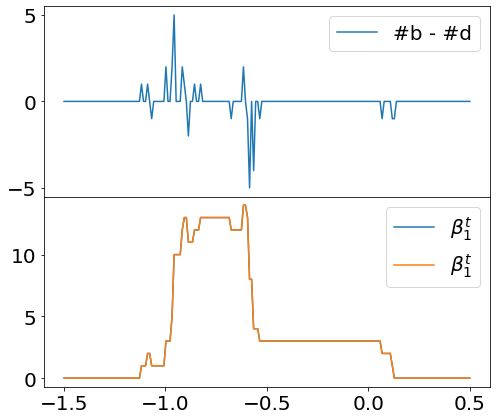

In [ ]:
fig, axs = plt.subplots(2, figsize=(8, 7))
fig.subplots_adjust(hspace=0.0, wspace=0.3)
ax1 = axs[0]
ax2 = axs[1]

ax1.plot(log_scales,b_1+b_2-d_1-d_2,label="#b - #d")
# ax1.plot(log_scales,b_1+b_2-d_1d_2,label="#b - #d")
ax1.set(xticks=[])

ax1.legend()
ax2.plot(log_scales,betti_1, label = r'$\beta_1^t$')
ax2.plot(log_scales,np.cumsum(b_1 - d_1), label = r'$\beta_1^t$')
#ax2.set_ylabel(r'$c(t)$')#, color="green")
#ax2.set(xlabel=r'$\log(t)$')#,ylim=(-0.1,1.1))
ax2.legend()
#plt.savefig(root_fig +'SBM_persistence_hierarchy.pdf', dpi=fig.dpi,bbox_inches='tight')

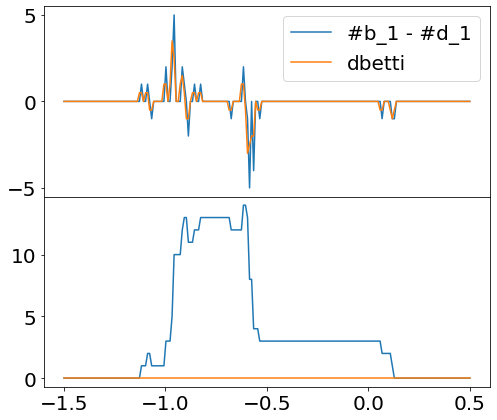

In [ ]:
fig, axs = plt.subplots(2, figsize=(8, 7))
fig.subplots_adjust(hspace=0.0, wspace=0.3)
ax1 = axs[0]
ax2 = axs[1]

ax1.plot(log_scales,b_1-d_1,label="#b_1 - #d_1")
ax1.plot(log_scales,np.gradient(betti_1, 1),label="dbetti")
ax1.set(xticks=[])

ax1.legend()
ax2.plot(log_scales,betti_1, label = r'$\beta_1^t$')
ax2.plot(log_scales,betti_2, label = r'$\beta_1^t$')

In [ ]:
np.array_equal(betti_1,np.cumsum(b_1-d_1))

True

In [ ]:
(b_1-d_1)[(b_1-d_1)!=np.gradient(betti_1, 1)]

array([ 0.,  1.,  0.,  1.,  0., -1.,  0.,  2.,  0.,  2.,  5.,  0.,  2.,
        1.,  0., -2.,  0.,  1.,  0.,  1.,  0., -1.,  0.,  2.,  0., -1.,
       -5.,  0., -4.,  0., -1.,  0., -1.,  0., -1.])

In [ ]:
np.gradient(betti_1, 1)[(b_1-d_1)!=np.gradient(betti_1, 1)]

array([ 0.5,  0.5,  0.5,  0.5, -0.5, -0.5,  1. ,  1. ,  1. ,  3.5,  2.5,
        1. ,  1.5,  0.5, -1. , -1. ,  0.5,  0.5,  0.5,  0.5, -0.5, -0.5,
        1. ,  1. , -0.5, -3. , -2.5, -2. , -2. , -0.5, -0.5, -0.5, -0.5,
       -0.5, -0.5])

In [ ]:
np.where((b_1 - d_1)<0)

(array([ 43,  61,  82,  90,  91,  93,  96, 156, 161, 162]),)

In [ ]:
MS_results["selected_partitions"]

[72, 122, 185]

In [ ]:
np.array_equal(partitions[96],partitions[122])

True

[Text(0.5, 0, '$\\log(t)$')]

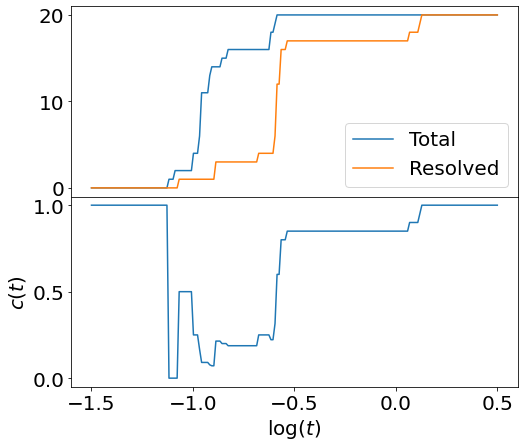

In [ ]:
fig, axs = plt.subplots(2, figsize=(8, 7))
fig.subplots_adjust(hspace=0.0, wspace=0.3)
ax1 = axs[0]
ax2 = axs[1]

ax1.plot(log_scales,total_1,label="Total")
ax1.plot(log_scales,resolved_1,label="Resolved")
ax1.set(xticks=[])

ax1.legend()
ax2.plot(log_scales,c)#, label = r'$\beta_1^t$')
ax2.set_ylabel(r'$c(t)$')#, color="green")
ax2.set(xlabel=r'$\log(t)$')#,ylim=(-0.1,1.1))
#ax2.legend()
#plt.savefig(root_fig +'SBM_persistence_hierarchy.pdf', dpi=fig.dpi,bbox_inches='tight')